# Decision Tree

### Importing libraries

In [171]:
# Calling the scikit learn datasets of forest covertypes
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.utils import Bunch
import time
pd.set_option('display.max_rows', None)  # Mostrar todas las filas
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', None)  # No truncar las columnas

### Apliying feature engineering and selecting features on tree different datasets

In [172]:
breast_cancer = load_breast_cancer()

df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
#df['target'] = breast_cancer.target

#print(df.head(30))
f1 = df[["mean radius","mean texture","mean perimeter","mean area","mean smoothness"]]
f2 = df[["mean compactness","mean concavity","mean concave points","mean symmetry"]]
f3 = df[["mean fractal dimension","radius error","texture error","perimeter error"]]
f4 = df[["area error","smoothness error","compactness error","concavity error"]]
f5 = df[["concave points error","symmetry error","fractal dimension error"]]
f6 = df[["worst radius","worst texture","worst perimeter","worst area"]]
f7 = df[["worst smoothness","worst compactness","worst concavity"]]
f8 = df[["worst concave points","worst symmetry","worst fractal dimension"]]

#df = f1
# Selecting columns
# df = df[[]]
data_dict = {'data': df.values, 'target': breast_cancer.target, 'feature_names': df.columns, 'target_names': breast_cancer.feature_names}

breast_cancer = Bunch(**data_dict)
#print(breast_cancer.target_names)
#print(type(breast_cancer))
#print(df.shape)
#print(f1.head(30))
#print(y)
#print(df.iloc[50:101,:])
#print(df)


In [173]:
def switch_case(argument):
    switcher = {
        0: breast_cancer,
        1: "second bunch",
        2: "third bunch"
    }
    return switcher.get(argument, "Invalid option")

selected_bunch = switch_case(0)

x = breast_cancer.data
y = breast_cancer.target

In [174]:
import math
import numpy as np
from pprint import pprint
from sklearn.model_selection import train_test_split

def entropy_func(c, n):
    return -(c*1.0/n)*math.log(c*1.0/n, 2)

def entropy_cal(c1, c2):
    #entropy between class 1 and 2
    if c1== 0 or c2 == 0:  # when there is only one class in the group, entropy is 0
        return 0
    return entropy_func(c1, c1+c2) + entropy_func(c2, c1+c2)

# One versus All
# c1,c2,c3, .., cm
# c1, *
# c2, *
# c3, *
# ...
# cm, *

#each class versus the others
def entropy_of_one_division(division): 
    s = 0
    n = len(division)
    classes = set(division)
    for c in classes:   # for each class, get entropy
        n_c = sum(division==c)
        e = n_c*1.0/n * entropy_cal(sum(division==c), sum(division!=c)) # weighted avg
        s += e
    return s, n

# The whole entropy
def get_entropy(y_predict, y_real):
    if len(y_predict) != len(y_real):
        print('They have to be the same length')
        return None
    n = len(y_real)
    s_true, n_true = entropy_of_one_division(y_real[y_predict]) # left hand side entropy
    s_false, n_false = entropy_of_one_division(y_real[~y_predict]) # right hand side entropy
    s = n_true*1.0/n * s_true + n_false*1.0/n * s_false # overall entropy, again weighted average
    return s



class DecisionTreeClassifier(object):
    def __init__(self, max_depth,bunch):
        self.depth = 0
        self.bunch = bunch
        self.max_depth = max_depth
    
    def fit(self, x, y, par_node={}, depth=0):
        if par_node is None: 
            return None
        elif len(y) == 0:
            return None
        elif self.all_same(y):
            return {'val':y[0]}
        elif depth >= self.max_depth:
            return None
        else: 
            col, cutoff, entropy = self.find_best_split_of_all(x, y)    # find one split given an information gain 
            y_left = y[x[:, col] < cutoff]
            y_right = y[x[:, col] >= cutoff]
            par_node = {'col': self.bunch.feature_names[col], 'index_col':col,
                        'cutoff':cutoff,
                       'val': np.round(np.mean(y))}
            par_node['left'] = self.fit(x[x[:, col] < cutoff], y_left, {}, depth+1)
            par_node['right'] = self.fit(x[x[:, col] >= cutoff], y_right, {}, depth+1)
            self.depth += 1 
            self.trees = par_node
            return par_node
    
    #all features versus values, get best
    def find_best_split_of_all(self, x, y):
        #print(x.shape, y.shape)
        col = None
        min_entropy = 1
        cutoff = None
        for i, c in enumerate(x.T):
            entropy, cur_cutoff = self.find_best_split(c, y)
            if entropy == 0:    # find the first perfect cutoff. Stop Iterating
                return i, cur_cutoff, entropy
            elif entropy <= min_entropy:
                min_entropy = entropy
                col = i
                cutoff = cur_cutoff
        return col, cutoff, min_entropy
    
    #one feature versus values
    def find_best_split(self, col, y):
        min_entropy = 10
        n = len(y)
        for value in set(col):
            y_predict = col < value #get which ones are less than
            my_entropy = get_entropy(y_predict, y)
            if my_entropy <= min_entropy:
                min_entropy = my_entropy
                cutoff = value
        return min_entropy, cutoff
    
    def all_same(self, items):
        return all(x == items[0] for x in items)
                                           
    def predict(self, x):
        tree = self.trees
        results = np.array([0]*len(x))
        for i, c in enumerate(x):
            results[i] = self._get_prediction(c)
        return results
    
    def _get_prediction(self, row):
        cur_layer = self.trees
        while cur_layer.get('cutoff'):
            if row[cur_layer['index_col']] < cur_layer['cutoff']:
                cur_layer = cur_layer['left']
            else:
                cur_layer = cur_layer['right']
        else:
            return cur_layer.get('val')

In [175]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=45)


dt_model = DecisionTreeClassifier(max_depth=12,bunch=selected_bunch)

t1 = time.time()
tree = dt_model.fit(X_train, y_train)
t2 = time.time()

tp_tree = t2-t1

pprint(tree)

X_train.shape

{'col': 'worst perimeter',
 'cutoff': 117.7,
 'index_col': 22,
 'left': {'col': 'worst concave points',
          'cutoff': 0.1359,
          'index_col': 27,
          'left': {'col': 'worst area',
                   'cutoff': 787.9,
                   'index_col': 23,
                   'left': {'col': 'worst texture',
                            'cutoff': 33.37,
                            'index_col': 21,
                            'left': {'val': 1},
                            'right': {'col': 'worst texture',
                                      'cutoff': 33.75,
                                      'index_col': 21,
                                      'left': {'val': 0},
                                      'right': {'val': 1},
                                      'val': 1.0},
                            'val': 1.0},
                   'right': {'col': 'worst texture',
                             'cutoff': 27.66,
                             'index_col': 21,
             

(398, 30)

In [176]:
y_pred = dt_model.predict(X_test)
print(y_pred)
print(y_test)

[0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1
 1 0 0 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 0 1
 1 0 1 0 1 1 0 0 0 1 0 1 0 1 0 1 0 1 1 1 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1
 1 1 0 1 1 1 0 0 0 1 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1
 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 0 0 0 0 1 1 1 1]
[1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1
 1 0 0 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 0 0 1
 1 0 1 0 1 1 0 0 0 1 0 1 0 1 0 0 0 1 1 1 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1
 1 0 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1
 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 0 0 0 0 1 1 1 1]


In [177]:
from sklearn.tree import DecisionTreeClassifier as sclearn_dt_model

sclear_dt_model = sclearn_dt_model(max_depth=12)
t1_sc = time.time()
sclear_dt_model.fit(X_train, y_train)
t2_sc = time.time()

tp_sc_tree = t2_sc-t1_sc

y_pred_sclearn_dt = sclear_dt_model.predict(X_test)
print(y_pred_sclearn_dt)
print(y_test)





[0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1
 1 0 0 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 0 0 1
 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1
 1 1 0 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 0 0 0 0 1 1 1 1]
[1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1
 1 0 0 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 0 0 1
 1 0 1 0 1 1 0 0 0 1 0 1 0 1 0 0 0 1 1 1 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1
 1 0 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1
 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 0 0 0 0 1 1 1 1]


In [178]:
def score(y_pred, y_test):        
    return float(sum(y_pred == y_test))/ float(len(y_test))


pd.DataFrame([[score(y_pred, y_test), score(y_pred_sclearn_dt,y_test)],[tp_tree,tp_sc_tree]],
             ['Score',"Fit time"],    
             ['Our Implementation', 'Sklearn\'s Implementation'])


,Our Implementation,Sklearn's Implementation
Score,0.941520,0.918129
Fit time,7.200907,0.000000


# Metricas

## Accuracy

In [179]:
def reverse_y_pred(y_pred):
    y_pred_reverse = y_pred
    for i in range(len(y_pred)):
        if y_pred_reverse[i] == 0:
            y_pred_reverse[i] = 1
        else:
            y_pred_reverse[i] = 0
    return y_pred_reverse

def fp_fn(y_pred_r,y_test):
    fp = 0
    fn = 0
    for i in range(len(y_test)):
        if y_pred_r[i] == y_test[i] == 1:
            fn += 1
        elif y_pred_r[i] == y_test[i] == 0:
            fp += 1
    return fp,fn

In [180]:
y_pred_list = list(y_pred)
y_pred_r = reverse_y_pred(y_pred_list)

fp,fn = fp_fn(y_pred_r,list(y_test))
tp = y_pred_list.count(0)
tn = y_pred_list.count(1)
acurracy = (tp+tn)/(tp+tn+fp+fn)


y_pred_sclearn_dt_list = list(y_pred_sclearn_dt)
y_pred_scrlearn_dt_r = reverse_y_pred(y_pred_sclearn_dt)

fp_sclearn_dt,fn_sclearn_dt = fp_fn(y_pred_scrlearn_dt_r,y_test)
tp_sclearn_dt = y_pred_sclearn_dt_list.count(0)
tn_sclearn_dt = y_pred_sclearn_dt_list.count(1)
div_sclearn_dt = (tp_sclearn_dt+tn_sclearn_dt+fp_sclearn_dt+fn_sclearn_dt)
acurracy_sclearn_dt = (tp_sclearn_dt+tn_sclearn_dt)/div_sclearn_dt

pd.DataFrame([[acurracy, acurracy_sclearn_dt]],
             ['Acurracy'],    
             ['Our Implementation', 'Sklearn\'s Implementation'])

,Our Implementation,Sklearn's Implementation
Acurracy,0.944751,0.924324


## Precision

In [181]:
precision = tp/(tp+fp)
precision_sclearn_dt = tp_sclearn_dt/(tp_sclearn_dt+fp_sclearn_dt)
pd.DataFrame([[precision, precision_sclearn_dt]],
             ['Precision'],    
             ['Our Implementation', 'Sklearn\'s Implementation'])

,Our Implementation,Sklearn's Implementation
Precision,0.942149,0.846154


## Recall

In [182]:
recall = tp/(tp+fn)
recall_sclearn_dt = tp_sclearn_dt/(tp_sclearn_dt+fn_sclearn_dt)
pd.DataFrame([[recall, recall_sclearn_dt]],
             ['Recall'],    
             ['Our Implementation', 'Sklearn\'s Implementation'])

,Our Implementation,Sklearn's Implementation
Recall,0.974359,0.932203


## F1 SCORE

In [185]:
f1score = 2*(precision*recall)/(precision+recall)
f1score_sclearn_dt = 2*(precision_sclearn_dt*recall_sclearn_dt)/(precision_sclearn_dt+recall_sclearn_dt)
pd.DataFrame([[f1score, f1score_sclearn_dt]],
             ['F1 SCORE'],    
             ['Our Implementation', 'Sklearn\'s Implementation'])


,Our Implementation,Sklearn's Implementation
F1 SCORE,0.957983,0.887097


## ROC (Receiver Operating Characteristic)

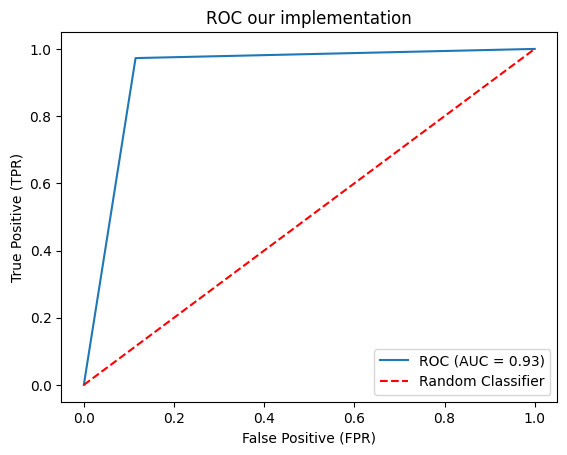

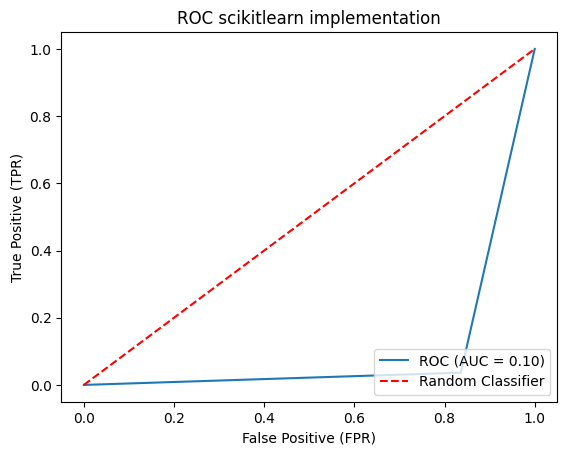

In [183]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, umbrales = roc_curve(y_test, y_pred)

auc = roc_auc_score(y_test, y_pred)

plt.plot(fpr, tpr, label='ROC (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')
plt.xlabel('False Positive (FPR)')
plt.ylabel('True Positive (TPR)')
plt.title('ROC our implementation')
plt.legend(loc='lower right')
plt.show()

fpr, tpr, umbrales = roc_curve(y_test, y_pred_sclearn_dt)

auc_sclearn_dt = roc_auc_score(y_test, y_pred_sclearn_dt)

plt.plot(fpr, tpr, label='ROC (AUC = {:.2f})'.format(auc_sclearn_dt))
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')
plt.xlabel('False Positive (FPR)')
plt.ylabel('True Positive (TPR)')
plt.title('ROC scikitlearn implementation')
plt.legend(loc='lower right')
plt.show()

## AUC (Area Under the Curve)

In [184]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, y_pred)
auc_sclearn_dt = roc_auc_score(y_test, y_pred_sclearn_dt)

pd.DataFrame([[auc, auc_sclearn_dt]],
             ['AUC'],    
             ['Our Implementation', 'Sklearn\'s Implementation'])


,Our Implementation,Sklearn's Implementation
AUC,0.928987,0.100149
